In [ ]:
!pip install nangs
!pip install torchdiffeq

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import nangs
import math 
import sympy as sp

device = "cuda" if torch.cuda.is_available() else "cpu"
nangs.__version__, torch.__version__

('2021.12.06', '1.13.1+cu116')

In [ ]:
# Build your own set of eigenfunctions
x,y = sp.symbols('x y', real=True)
p1 = -x + x**3
p2 = y - y**3 
phi1 = (p1 + 2*p2);
phi2 = (2*p1 - 3*p2);
phi = sp.Matrix([phi1,phi2]);
J = phi.jacobian([x,y]);
f = sp.simplify(J.inv()*sp.Matrix([[-5,0],[0,-1]])*phi)
F = f.jacobian([x,y])

# Linear and nonlinear parts of the dynamics
A = F.subs([(x,0),(y,0)]) 
fn = f - A*sp.Matrix([x,y]) 
E,W = np.linalg.eig(np.array(A.T).astype(np.float64)) 
w1 = W[:,0]; w2 = W[:,1]
l1 = E[0]; l2 = E[1]

# Relevant functions used for computation/comparision
p1= sp.lambdify((x,y),phi1)
p2= sp.lambdify((x,y),phi2)
g1 = np.dot(w1,fn)[0]; g2 = np.dot(w2,fn)[0] 
g1 = sp.lambdify((x,y),g1); g2 = sp.lambdify((x,y),g2)
f = sp.lambdify((x,y),tuple(f))

In [ ]:
#Define the eigenfunction PDE

from nangs import PDE

lam = l1; 
class Eigen(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        grads = self.computeGrads(outputs, inputs)
        
        # compute loss
        dpdx, dpdy = grads[:, 0], grads[:, 1]
        x, y = inputs[:, 0], inputs[:, 1]
        p = outputs
        u, v = f(x, y)
        g = g1(x,y)
        return {'pde': -lam*p + u*dpdx + v*dpdy + g}

# instantiate pde
pde = Eigen(inputs=('x', 'y'), outputs='p')

# Prepare training data

In [ ]:
# define the sampler

from nangs import RandomSampler

sampler = RandomSampler({
    'x': [-0.45, 0.45], 
    'y': [-0.45, 0.45],
}, device=device, n_samples=2000)

pde.set_sampler(sampler)

In [ ]:
from torchdiffeq import odeint
from nangs import Dirichlet

H = lambda t,X : torch.vstack(f(X[0],X[1]) + (np.exp(-l1*t)*g1(X[0],X[1]),))

initial_condition1 = Dirichlet(
    RandomSampler({'x': [-0.45, 0.45], 'y': 0.45}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,50.]))[-1,2]},
    name="edge1"
)

initial_condition2 = Dirichlet(
    RandomSampler({'x': [-0.45, 0.45], 'y': -0.45}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,50.]))[-1,2]},
    name="edge2"
)

initial_condition3 = Dirichlet(
    RandomSampler({'x': 0.45, 'y': [-0.45, 0.45]}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,50.]))[-1,2]},
    name="edge3"
)

initial_condition4 = Dirichlet(
    RandomSampler({'x': -0.45, 'y': [-0.45, 0.45]}, device=device, n_samples=100), 
    lambda inputs: {'p' : odeint(H, torch.hstack((inputs['x'].reshape(-1,1), inputs['y'].reshape(-1,1), torch.zeros(len(inputs['x']),1))).T, torch.tensor([0.,50.]))[-1,2]},
    name="edge4"
)

pde.add_boco(initial_condition1)
pde.add_boco(initial_condition2)
pde.add_boco(initial_condition3)
pde.add_boco(initial_condition4)


In [ ]:
initial_condition1.sample(3)

({'x': tensor([-0.2754,  0.3690,  0.3392]),
  'y': tensor([0.4500, 0.4500, 0.4500])},
 {'p': tensor([-0.0642, -0.1037, -0.0975])})

# Train

In [ ]:
# solve

from nangs import MLP

LR = 1e-2
N_STEPS = 2000
NUM_LAYERS = 3
NUM_HIDDEN = 128

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

{'pde': 0.00112, 'edge1': 7e-05, 'edge2': 6e-05, 'edge3': 2e-05, 'edge4': 2e-05}: 100%|██████████| 2000/2000 [1:24:12<00:00,  2.53s/it]

CPU times: user 1h 23min 16s, sys: 12.5 s, total: 1h 23min 29s
Wall time: 1h 24min 12s


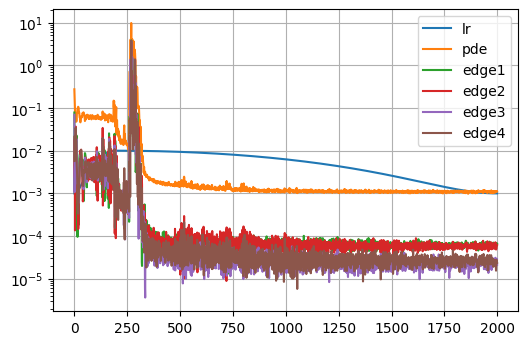

In [ ]:
# plot loss history
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

#**Evaluate**

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

x = np.linspace(-0.45,0.45,100)
y = np.linspace(-0.45,0.45,100)

_x, _y = np.meshgrid(x, y)

grid = np.stack(np.meshgrid(x, y), -1).reshape(-1, 2)
X = torch.from_numpy(grid).float().to(device)
p = pde.eval(X)
p = p.cpu().numpy()

In [ ]:
X.requires_grad_(True)
p = mlp(X)
grads = pde.computeGrads(p,X)
dpdx, dpdy = grads[:, 0].detach().numpy().reshape((len(_y),len(_x))), grads[:, 1].detach().numpy().reshape((len(_y),len(_x)))
p = p.detach().numpy().reshape((len(_y),len(_x)))
u,v = f(_x,_y)
g = g1(_x,_y)
error = -lam*p + u*dpdx.reshape((len(_y),len(_x))) + v*dpdy.reshape((len(_y),len(_x))) + g

# Visualize

In [ ]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

"""
# Matplotlib not pretty 
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(_x, _y, p + w1[0]*_x + w1[1]*_y, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.plot_surface(_x, _y, -(w1[0]/2)*p2(_x,_y), cmap=cm.spring, linewidth=0, antialiased=False)
plt.show()
"""

fig = go.Figure(data=[go.Surface(z=(-w1[0]/2)*(2*_x**3+3*_y**3), x=_x, y=_y, showscale=False, opacity=0.3),
                      go.Surface(z=p, x=_x, y=_y) ])
fig.update_layout(title='$Nonlinear \,part:\; 2x^3 + 3y^3$', autosize=False,
                  width=600, height=500,
                  margin=dict(l=15, r=20, b=15, t=30))

fig.update_layout(scene_aspectmode='cube')
fig.show()


In [ ]:
# Save if all looks A-OK !
from google.colab import files
torch.save(mlp.state_dict(),'checkpoint.pth')
files.download('checkpoint.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>